Model Selection: Beyond Black-Scholes

#### <u>The Black-Scholes Model</u>

Solving the Black-Scholes Equation Yields:

$$C = S_t \Phi(d_1) - Ke^{-rt} \Phi(d_2)$$

$$\Phi(x) = \int_{-\infty}^x \frac{1}{\sqrt{2\pi}}e^{\frac{-s^2}{2}}ds$$

$$d_1 = \frac{ln(\frac{S_t}{K})+(r+\frac{\sigma^2}{2})t}{\sigma \sqrt{t}}$$

$$d_2 = d_1 - \sigma \sqrt{t}$$

Mathematically, the Black-Scholes formula is a functional, a map from $\mathbb{R}^5 \rightarrow \mathbb{R}$:

$BS: (S, K, r, \sigma, T) \mapsto C$

Where:
- $S \in \mathbb{R}^+ $ (spot price)
- $K \in \mathbb{R}^+$ (strike price) 
- $r \in \mathbb{R}$ (risk-free rate)
- $\sigma \in \mathbb{R}^+$ (volatility)
- $T \in \mathbb{R}^+$ (time to expiry)
$\mapsto C \in \mathbb{R}^+$ (call option price)

Realistically, the market or contract selection determines $(S, K, r, T)$

$$\implies BS: (\sigma | S, K, r, T) \mapsto C$$

That is, given the market and contract parameters $(S, K, r, T)$ we choose a volatility to price the options according to the assumptions of the Black-Scholes model.


In [61]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Choose a renderer that works almost everywhere
pio.renderers.default = "iframe"   # change to "browser" if needed

# Data
strikes = [90, 95, 100, 105, 110]
maturities = [1/12, 3/12, 6/12, 1, 2]

market_vols = np.array([
    [28.0, 24.5, 22.0, 20.5, 19.5],
    [27.5, 24.0, 21.8, 20.3, 19.3],
    [27.0, 23.5, 21.5, 20.0, 19.0],
    [26.5, 23.0, 21.2, 19.8, 18.8],
    [26.0, 22.5, 21.0, 19.5, 18.5]
])

X, Y = np.meshgrid(strikes, maturities)

previous_vol = 20.0
previous_vol_surface = np.full_like(market_vols, previous_vol)

def plot_vol_surfaces(bs_vol=22.0):
    current_vol_surface = np.full_like(market_vols, bs_vol)

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type':'surface'}, {'type':'surface'}]],
        subplot_titles=("Market Implied Vol Surface",
                        f"Black-Scholes Surface (σ = {bs_vol:.2f}%)")
    )

    # Market surface
    fig.add_trace(
        go.Surface(x=X, y=Y, z=market_vols, colorscale='Viridis', opacity=0.85),
        row=1, col=1
    )

    # Previous & current BS surfaces
    fig.add_trace(
        go.Surface(x=X, y=Y, z=previous_vol_surface, colorscale='Reds', opacity=0.25, showscale=False),
        row=1, col=2
    )
    fig.add_trace(
        go.Surface(x=X, y=Y, z=current_vol_surface, colorscale='Blues', opacity=0.85, showscale=False),
        row=1, col=2
    )

    fig.update_layout(
        width=950, height=550,
        scene=dict(
            xaxis_title="Strike",
            yaxis_title="Maturity (yrs)",
            zaxis_title="Vol (%)"
        ),
        scene2=dict(
            xaxis_title="Strike",
            yaxis_title="Maturity (yrs)",
            zaxis_title="Vol (%)",
            zaxis=dict(range=[np.min(market_vols)-2, np.max(market_vols)+2])
        )
    )

    fig.show()

# Example (change number to see different constant vols)
plot_vol_surfaces(bs_vol=24.0)


In [63]:
# Calculate skew relative to flat 20% BS vol
flat_bs_vol = 20.0
spot = 100

# Get market volatilities for each strike at each maturity
market_skew = market_vols[0]  # Take first maturity for simplicity
bs_skew = [flat_bs_vol] * len(strikes)

# Create figure
fig = go.Figure()

# Add market skew line
fig.add_trace(
    go.Scatter(
        x=strikes,
        y=market_skew,
        name='Market Volatility Skew',
        line=dict(color='#00b3ff', width=3)
    )
)

# Add flat BS vol line
fig.add_trace(
    go.Scatter(
        x=strikes,
        y=bs_skew,
        name='Black-Scholes Volatility',
        line=dict(color='#ff9100', width=3, dash='dash')
    )
)

# Update layout
fig.update_layout(
    title='Market, Black-Scholes Skew',
    xaxis_title='Strike Price',
    yaxis_title='Implied Volatility (%)',
    width=900,
    height=500,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.95,
        xanchor="right",
        x=0.95
    ),
    font=dict(color='white')
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')

fig.show()



#### <u>Problem with Black-Scholes (Consistency): Statistical and Static Arbitrage</u>

The simplest example of why we need to demand consistent pricing can be seen above.

- Volatility increases $\rightarrow$ Option Price increase
- Volatility decreases $\rightarrow$ Option Price decrease

I am constantly quoting prices against the market that are over and undervalued. Imagine if I were selling jewels all for the same price, and others knew the market price differed for diamonds and gold they could sell me what I overvalue and buy what is undervalued and I'll get killed.

We need a way to **consistently and efficiently** quote prices. 


#### <u>Extensions and Alternative Models</u>

The Black-Scholes model assumes a geometric Brownian motion stochastic differential equation for the underlying leading to the constant volatility assumption
$$\frac{dS_t}{S_t} = \mu dt + \sigma dW_t$$

To better match market prices and account for the volatility smile/skew, we can use:

 - **Local Volatility Models - Make volatility a deterministic function of spot and time:**
    $$\frac{dS_t}{S_t} = \mu dt + \sigma(S_t,t) dW_t$$
    - Dupire's formula provides a way to compute local volatility from market prices
    - Ensures consistent pricing with vanilla options

 - **Stochastic Volatility Models - Make volatility follow its own stochastic process:**
    $$\begin{align}
    \frac{dS_t}{S_t} &= \mu dt + \sqrt{v_t} dW^1_t \\
    dv_t &= \kappa(\theta - v_t)dt + \xi\sqrt{v_t}dW^2_t
    \end{align}$$
    - Heston model is a popular example
    - Adds correlation between spot and vol ($\rho dt = dW^1_t dW^2_t$)
    - Better captures dynamics of implied volatility surface

**Functional Framework - The Heston model as a map:**
      $$\begin{align}
      \mathcal{H}: \mathbb{R}^7 &\rightarrow \mathbb{R} \\
      (\kappa, \theta, \xi, \rho, v_0, K, T) &\mapsto \text{Price}
      \end{align}$$
      where $K$ is the strike price and $T$ is time to maturity
  


 These models help trading desks price exotic options more accurately and manage risk better.

In [66]:
from scipy.stats import norm
# Heston model parameters
kappa = 2.0  # Mean reversion speed
theta = .08  # Long-run variance
xi = 1.4  # Vol of vol
rho = -0.7  # Correlation
v0 = (flat_bs_vol/100)**2  # Initial variance

# Risk-free rate and time to maturity
r = 0.02
T = 1.0

# Simulation parameters
n_paths = 10000
n_steps = 252  # Daily steps
dt = T/n_steps

# Generate correlated Brownian motions
dW1 = np.random.normal(0, np.sqrt(dt), (n_paths, n_steps))
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), (n_paths, n_steps))

# Simulate Heston paths
S = np.zeros((n_paths, n_steps + 1))
v = np.zeros((n_paths, n_steps + 1))
S[:, 0] = spot
v[:, 0] = v0

for t in range(n_steps):
    v[:, t+1] = np.maximum(v[:, t] + kappa*(theta - v[:, t])*dt + xi*np.sqrt(v[:, t])*dW2[:, t], 0)
    S[:, t+1] = S[:, t] * np.exp((r - 0.5*v[:, t])*dt + np.sqrt(v[:, t])*dW1[:, t])

# Calculate Heston implied volatilities
heston_vols = []
for K in strikes:
    # Calculate call option prices
    payoffs = np.maximum(S[:, -1] - K, 0)
    heston_price = np.exp(-r*T) * np.mean(payoffs)
    
    # Find implied vol using Newton-Raphson
    def bs_price(sigma):
        d1 = (np.log(spot/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        return spot*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    
    def vega(sigma):
        d1 = (np.log(spot/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return spot*np.sqrt(T)*norm.pdf(d1)
    
    sigma = flat_bs_vol/100  # Initial guess
    for _ in range(50):
        diff = bs_price(sigma) - heston_price
        if abs(diff) < 1e-5:
            break
        sigma = sigma - diff/vega(sigma)
    
    heston_vols.append(sigma*100)

# Create new figure
fig = go.Figure()

# Add market skew line
fig.add_trace(
    go.Scatter(
        x=strikes,
        y=market_skew,
        name='Market Volatility Skew',
        line=dict(color='#00b3ff', width=3)
    )
)

# Add flat BS skew line
fig.add_trace(
    go.Scatter(
        x=strikes,
        y=[flat_bs_vol]*len(strikes),
        name='Black-Scholes Volatility',
        line=dict(color='#ff9100', width=3, dash='dash')
    )
)

# Add Heston skew line
fig.add_trace(
    go.Scatter(
        x=strikes,
        y=heston_vols,
        name='Heston Model Skew',
        line=dict(color='#00ff00', width=3, dash='dot')
    )
)

# Update layout
fig.update_layout(
    title='Market, Black-Scholes, Heston Skew',
    xaxis_title='Strike Price',
    yaxis_title='Implied Volatility (%)',
    width=900,
    height=500,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.95,
        xanchor="right",
        x=0.95
    ),
    font=dict(color='white')
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')

fig.show()


### Solutions to Pricing Functionals for Heston



Establishing Pricing PDEs:

  **Pricing Function:** For a European call option with strike K and maturity T:
  $$C(S_t,v_t,t) = \mathbb{E}_t\left[e^{-r(T-t)}\max(S_T - K, 0)\right]$$
  where $S_T$ follows the Heston dynamics above. The expectation can be computed:
  1. Using Monte Carlo simulation of paths (as shown in code below)
  2. Using semi-analytical Fourier methods with characteristic function
  3. Using finite difference methods to solve the PDE:
  $$\begin{align}
  \frac{\partial C}{\partial t} + \frac{1}{2}vS^2\frac{\partial^2 C}{\partial S^2} &+ \rho\xi vS\frac{\partial^2 C}{\partial S\partial v} + \frac{1}{2}\xi^2v\frac{\partial^2 C}{\partial v^2} \\
  &+ rS\frac{\partial C}{\partial S} + \kappa(\theta-v)\frac{\partial C}{\partial v} - rC = 0
  \end{align}$$

 **Remark:** Desks don't just use the price generated by these models, nor do they blindly hedge with the model greeks - we know what assumptions are associated with which models and adjust our decision making in uncertainty accordingly in a discretionary capacity usually based on desk heuristics!


Pricing Functional Solutions:

- Closed-Form Solutions

- Tricks (i.e. FFT)

- Partial Differential Equation Schemes (Finite-Differences)

- Stochastic Process Simulation 

#### <u>Pricing Notation from Horvath et al. 2019</u>

The market dictates the price for a set of contracts $\zeta$ a vector of instruments to price $\mathbb{R}^m, m \in \mathbb{N}$

Given a parameter set $\theta \in \Theta \subset \mathbb{R}^n$ and model framework $\mathcal{M}$ we can produce a price for the given framework by the pricing map $P : \mathcal{M}(\theta, \zeta) \mapsto \mathbb{R}^m$

$$P(\mathcal{M}(\theta, \zeta)) \mapsto \mathbb{R}^m$$

For our Heston model:

$$\theta = (\kappa, \theta, \xi, \rho, v_0) \quad \mathcal{M} = \mathcal{H} \text{ (Heston)}$$
$$P(\mathcal{H}(\theta, \zeta)) \mapsto \mathbb{R}^m$$

However, if we use simulation or some sort of numerical PDE solver we have

$$\tilde{P}(\mathcal{H}(\theta, \zeta)) \approx P(\mathcal{H}(\theta, \zeta))$$

### Model Calibration to an Implied Volatility Surface

Once we determine *how* we will produce a price (Closed-Form, Quasi-Closed-Form, Simulation, Numerical PDE)

We can go about finding the values of the parameters to use $\theta$ by calibrating our model to a market volatility surface

This is equivalent to solving the following minimization problem which yields the parameters to use

$$\theta^* = argmin_{\theta \in \Theta} \delta (\tilde{P}(\mathcal{H}(\theta, \zeta)), \mathcal{P}^{MKT}(\zeta))$$

Where $\delta$ is some measure of distance between the model price for instruments $\zeta$ given by parameters $\theta$ and the corresponding market prices.

**Don't get lost in the notation!**

$\theta^*$ just tells us the values of the Heston parameters $(\kappa, \theta, \xi, \rho, v_0, K, T)$ to use based on market prices!

#### <u>Efficiency Concerns</u>

- Simulation MC schemes can be SLOW - fitting is itterative meaning we have to iteratively simulate prices...

- Price/IVol space - we can fit in the price space and conver to BS Ivols one to one

- Some schemes require full MC simulation (for example, a Volterra processes)

- We may approximate these functionals offline with neural networks

There is a lot to this process - I will have to punt on this topic and save it for another video!  

For the rest of the notebook herein, we can assume that we've found the parameters $\theta^*$ as $\hat{\theta}$ to use.

In [69]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import plotly.io as pio # Import plotly.io to save the plot

# Data for the volatility surface - precompute meshgrid
strikes = [90, 95, 100, 105, 110]
maturities = [1/12, 3/12, 6/12, 1, 2]    # in years
maturity_labels = ['1 Month', '3 Months', '6 Months', '1 Year', '2 Years']

# Market volatility values (in %)
market_vols = np.array([
    [28.0, 24.5, 22.0, 20.5, 19.5],  # 1 month
    [27.5, 24.0, 21.8, 20.3, 19.3],  # 3 months
    [27.0, 23.5, 21.5, 20.0, 19.0],  # 6 months
    [26.5, 23.0, 21.2, 19.8, 18.8],  # 1 year
    [26.0, 22.5, 21.0, 19.5, 18.5]   # 2 years
])

# Create meshgrid for 3D surface
X, Y = np.meshgrid(strikes, maturities)

def heston_paths(S0, v0, kappa, theta, xi, rho, r, T, N, M):
    """
    Simulate Heston paths using Euler discretization
    S0: initial stock price
    v0: initial variance
    kappa: mean reversion speed
    theta: long-run variance
    xi: volatility of variance
    rho: correlation
    r: risk-free rate
    T: time horizon
    N: number of time steps
    M: number of paths
    """
    dt = T/N
    
    # Initialize arrays
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))
    S[0] = S0
    v[0] = v0
    
    # Generate correlated random numbers
    Z1 = np.random.standard_normal((N, M))
    Z2 = rho * Z1 + np.sqrt(1-rho**2) * np.random.standard_normal((N, M))
    
    # Simulate paths
    for i in range(N):
        # Ensure variance remains non-negative
        v[i+1] = np.maximum(v[i] + kappa*(theta - v[i])*dt + xi*np.sqrt(v[i]*dt)*Z1[i], 0)
        S[i+1] = S[i] * np.exp((r - 0.5*v[i])*dt + np.sqrt(v[i]*dt)*Z2[i])
    
    return S, v

def bs_implied_vol(S0, K, T, r, price, call=True):
    """Calculate BS implied volatility using Newton-Raphson"""
    def bs_price(sigma):
        # Black-Scholes price formula
        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        if call:
            return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        else:
            return K*np.exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)
    
    sigma = 0.3  # Initial guess for volatility
    for _ in range(100): # Max 100 iterations for convergence
        price_diff = bs_price(sigma) - price
        if abs(price_diff) < 1e-5: # Convergence criterion
            return sigma
        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        vega = S0*np.sqrt(T)*norm.pdf(d1) # Vega for Newton-Raphson
        if vega == 0: # Avoid division by zero
            return sigma
        sigma = sigma - price_diff/vega
        if sigma <= 0: # Ensure sigma remains positive
            sigma = 0.01
    return sigma # Return the best estimate if not converged

# Fixed parameters for plot
S0 = 100
v0 = 5.208/100  # Initial variance (converted from percentage)
kappa = 2.0
theta = 0.04
xi = 0.3
rho = -0.7
r = 0.02

# Calculate Heston implied volatility surface
heston_vols = np.zeros_like(market_vols)
N_paths = 100000 # Number of simulation paths

for i, T in enumerate(maturities):
    N_steps = int(T * 252)  # Daily steps (assuming 252 trading days in a year)
    if N_steps == 0: # Ensure at least one step for very short maturities
        N_steps = 1
    for j, K in enumerate(strikes):
        # Simulate paths
        S, v = heston_paths(S0, v0, kappa, theta, xi, rho, r, T, N_steps, N_paths)
        
        # Calculate option price (for a call option)
        payoffs = np.maximum(S[-1] - K, 0)
        price = np.exp(-r*T) * np.mean(payoffs)
        
        # Convert to implied vol
        try:
            impl_vol = bs_implied_vol(S0, K, T, r, price) * 100  # Convert to percentage
            heston_vols[i,j] = impl_vol
        except Exception as e:
            print(f"Could not calculate implied volatility for T={T}, K={K}: {e}")
            heston_vols[i,j] = np.nan # Assign NaN if calculation fails
# Create figure with two subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=('Heston Implied Volatility Surface', 'Market Implied Volatility Surface')
)

# Add Heston surface
fig.add_trace(
    go.Surface(x=X, y=Y, z=heston_vols, colorscale='Viridis', opacity=0.7, showscale=True),
    row=1, col=1
)

# Add Market surface
fig.add_trace(
    go.Surface(x=X, y=Y, z=market_vols, colorscale='Viridis', opacity=0.7, showscale=True),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title='Heston vs Market Implied Volatility Surfaces',
    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Maturity (Years)', 
        zaxis_title='Implied Volatility (%)',
        xaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        yaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        zaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        bgcolor='rgba(0,0,0,0)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    scene2=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Implied Volatility (%)',
        xaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        yaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        zaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)', range=[np.min(market_vols)-2, np.max(market_vols)+2]),
        bgcolor='rgba(0,0,0,0)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),
    width=1000,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white')
)

fig.show()


## Local Vol Model


In [71]:
import numpy as np
from scipy.stats import norm
from scipy.interpolate import RegularGridInterpolator, interp1d
import plotly.graph_objects as go

# ---------------------------
# User inputs (example)
# ---------------------------
spot = 100.0
r = 0.02

# strikes (1D)
strikes = np.linspace(60, 140, 41)

# maturities (in years) - if you only have a single maturity, make this length 1
maturities = np.array([0.25, 0.5, 1.0, 2.0])  # example maturities

# implied_vols: shape (len(maturities), len(strikes)) in decimals (e.g. 0.2 for 20%)
# Replace this with your real market surface. This is a toy surface for demonstration.
implied_vols = np.zeros((len(maturities), len(strikes)))
for i, T in enumerate(maturities):
    # sample skew: ATM decreases with T a bit, wings higher vol
    implied_vols[i] = 0.25 - 0.05 * np.log(T + 0.01) + 0.15 * np.exp(-((strikes - spot)**2)/(2*(20 + 10*T)**2))

# If you only have a single maturity, you might instead set:
# maturities = np.array([1.0])
# implied_vols = np.array([market_skew/100.])  # convert % to decimals

flat_bs_vol = 20.0  # percent, used as initial guess and flat-BS line in plot
flat_bs_vol_dec = flat_bs_vol / 100.0

# ---------------------------
# Black-Scholes helpers
# ---------------------------
def bs_call_price(spot, K, r, T, sigma):
    if T <= 0:
        return max(spot - K, 0.0)
    sigma = np.maximum(sigma, 1e-12)
    d1 = (np.log(spot / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return spot * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_vol_from_price(mkt_price, spot, K, r, T, initial=0.2):
    # simple Newton-Raphson (bounded)
    if T <= 0:
        return 0.0 if mkt_price <= max(spot - K, 0.0) + 1e-12 else np.nan
    sigma = initial
    for _ in range(80):
        sigma = max(1e-12, sigma)
        d1 = (np.log(spot / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price = spot * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        vega = spot * norm.pdf(d1) * np.sqrt(T)
        diff = price - mkt_price
        if abs(diff) < 1e-8:
            break
        sigma -= diff / (vega + 1e-12)
    return sigma

# ---------------------------
# Build local volatility surface (Dupire) if full surface provided
# Otherwise fallback to time-homogeneous local-vol from single maturity
# ---------------------------
def build_local_vol_surface(strikes, maturities, implied_vols, spot, r):
    strikes = np.array(strikes)
    maturities = np.array(maturities)
    vol = np.array(implied_vols)  # shape (nT, nK)
    
    nT, nK = vol.shape
    # Compute call prices on the grid from implied vols
    C = np.zeros_like(vol)
    for iT, T in enumerate(maturities):
        for iK, K in enumerate(strikes):
            C[iT, iK] = bs_call_price(spot, K, r, T, vol[iT, iK])

    # Finite differences:
    eps = 1e-6
    dC_dT = np.zeros_like(C)
    # Time derivatives (use forward/backward differences)
    for iT in range(nT):
        if iT == 0:
            # forward
            dt = maturities[iT+1] - maturities[iT] + eps
            dC_dT[iT] = (C[iT+1] - C[iT]) / dt
        elif iT == nT-1:
            # backward
            dt = maturities[iT] - maturities[iT-1] + eps
            dC_dT[iT] = (C[iT] - C[iT-1]) / dt
        else:
            dt = maturities[iT+1] - maturities[iT-1] + eps
            dC_dT[iT] = (C[iT+1] - C[iT-1]) / dt * 0.5

    # Second derivative wrt K: central differences (d2C/dK2)
    d2C_dK2 = np.zeros_like(C)
    for iT in range(nT):
        for iK in range(nK):
            if iK == 0:
                dk = strikes[iK+1] - strikes[iK] + eps
                d2C_dK2[iT, iK] = (C[iT, iK+2] - 2*C[iT, iK+1] + C[iT, iK]) / (dk**2) if nK>2 else eps
            elif iK == nK-1:
                dk = strikes[iK] - strikes[iK-1] + eps
                d2C_dK2[iT, iK] = (C[iT, iK] - 2*C[iT, iK-1] + C[iT, iK-2]) / (dk**2) if nK>2 else eps
            else:
                dk1 = strikes[iK] - strikes[iK-1]
                dk2 = strikes[iK+1] - strikes[iK]
                # approximate using general central second difference
                d2C_dK2[iT, iK] = ( (C[iT, iK+1] - C[iT, iK])/(dk2) - (C[iT, iK] - C[iT, iK-1])/(dk1) ) / (0.5*(dk1+dk2) + eps)
    
    # Dupire formula: local variance at (K,T)
    local_var = np.zeros_like(C)
    for iT in range(nT):
        for iK, K in enumerate(strikes):
            denom = (K**2) * d2C_dK2[iT, iK]
            numer = 2.0 * dC_dT[iT, iK]
            if denom <= 0 or numer <= 0:
                local_var[iT, iK] = np.nan
            else:
                local_var[iT, iK] = numer / (denom + 1e-12)
    # Clean and take sqrt to get local vol
    # Replace NaNs by nearest positive neighbor (simple fill)
    # first set negative or nan to small positive
    local_var = np.where(np.isnan(local_var) | (local_var <= 0), np.nan, local_var)
    # simple inpainting: replace NaN by nearest row/column non-NaN (very naive)
    for iT in range(nT):
        for iK in range(nK):
            if np.isnan(local_var[iT, iK]):
                # find nearest non-nan
                found = False
                for radius in range(1, max(nT,nK)):
                    # search neighboring indices
                    for dt_ in range(-radius, radius+1):
                        for dk_ in range(-radius, radius+1):
                            iT2 = iT + dt_
                            iK2 = iK + dk_
                            if 0 <= iT2 < nT and 0 <= iK2 < nK and not np.isnan(local_var[iT2, iK2]):
                                local_var[iT, iK] = local_var[iT2, iK2]
                                found = True
                                break
                        if found: break
                    if found: break
                if not found:
                    local_var[iT, iK] = (flat_bs_vol_dec**2)
    local_vol = np.sqrt(np.maximum(local_var, 1e-12))

    # Create interpolator: arguments order (T, K) -> local_vol
    interp = RegularGridInterpolator((maturities, strikes), local_vol, bounds_error=False, fill_value=None)
    return interp, local_vol  # return the interpolator and grid for inspection

# Fallback: build time-homogeneous local vol func (sigma_loc(S) = implied_vol(K=S, T_single))
def build_time_homogeneous_local_vol(strikes, implied_vol_single_maturity):
    f = interp1d(strikes, implied_vol_single_maturity, fill_value='extrapolate', kind='cubic')
    def sigma_loc(t, S):
        return np.maximum(f(S), 1e-6)  # returns vol in decimals
    return sigma_loc

# Build local vol interpolator depending on provided surface shape
if implied_vols.ndim == 2 and implied_vols.shape[0] >= 2:
    local_vol_interp, local_vol_grid = build_local_vol_surface(strikes, maturities, implied_vols, spot, r)
    def sigma_loc(t, S):
        # interpolate local vol: if t exactly matches a maturity use that, else use nearest or interpolation
        # make sure S within strike range
        T_query = t
        pts = np.stack([np.full_like(S, T_query), S], axis=-1)
        # RegularGridInterpolator accepts shape (...,2) array, but if S is scalar handle properly
        out = local_vol_interp(pts)
        return np.maximum(out, 1e-6)
else:
    # fallback: use the single maturity implied surface (first row)
    implied_single = implied_vols[0] if implied_vols.ndim==2 else implied_vols
    sigma_timehom = build_time_homogeneous_local_vol(strikes, implied_single)
    def sigma_loc(t, S):
        # returns a scalar or array of local vol given S (in decimals)
        S_arr = np.array(S, copy=False)
        return sigma_timehom(t, S_arr)

# ---------------------------
# Monte Carlo under Local Volatility
# ---------------------------
n_paths = 20000
n_steps = 252
T_sim = 1.0
dt = T_sim / n_steps

rng = np.random.default_rng(seed=12345)
S_paths = np.full((n_paths, n_steps+1), spot)
# simulate via Euler-Maruyama in log form (multiplicative)
for step in range(n_steps):
    t = step * dt
    St = S_paths[:, step]
    # get sigma for each path (vectorized)
    sigmas = sigma_loc(t + dt, St)  # evaluate at t+dt for better stability (implicit-ish)
    sigmas = np.array(sigmas, copy=False).reshape(-1)
    dW = rng.normal(0.0, np.sqrt(dt), size=n_paths)
    # log-Euler update: S_{t+dt} = S_t * exp((r - 0.5*sigma^2)*dt + sigma * dW)
    S_paths[:, step+1] = St * np.exp((r - 0.5 * sigmas**2) * dt + sigmas * dW)

# ---------------------------
# Price options at T_sim and compute implied vol across strikes
# ---------------------------
heston_like_vols = []
for K in strikes:
    payoffs = np.maximum(S_paths[:, -1] - K, 0)
    price = np.exp(-r * T_sim) * np.mean(payoffs)
    sigma_iv = implied_vol_from_price(price, spot, K, r, T_sim, initial=flat_bs_vol_dec)
    heston_like_vols.append(sigma_iv * 100.0)  # convert to percent

# ---------------------------
# Prepare market skew vector for plotting (if you had single maturity)
# ---------------------------
# If the user started with a single maturity market skew, they can pass it here. 
# For demo, compute synthetic market skew at T_sim by interpolating the implied_vols grid:
if implied_vols.shape[0] >= 2:
    # interpolate implied vols to T_sim
    # simple time interpolation of the implied_vols matrix
    implied_vs_T = np.zeros(len(strikes))
    for iK, K in enumerate(strikes):
        implied_vs_T[iK] = np.interp(T_sim, maturities, implied_vols[:, iK])
    market_skew = implied_vs_T * 100.0
else:
    market_skew = implied_vols[0] * 100.0 if implied_vols.ndim==2 else implied_vols * 100.0

# ---------------------------
# Plot results with Plotly (keeps same styling as your original script)
# ---------------------------
fig = go.Figure()

# Market skew
fig.add_trace(go.Scatter(
    x=strikes, y=market_skew,
    name='Market Volatility Skew',
    line=dict(color='#00b3ff', width=3)
))

# Flat BS
fig.add_trace(go.Scatter(
    x=strikes, y=[flat_bs_vol]*len(strikes),
    name='Black-Scholes Volatility',
    line=dict(color='#ff9100', width=3, dash='dash')
))

# Local vol MC implied vols
fig.add_trace(go.Scatter(
    x=strikes, y=heston_like_vols,
    name='Local Vol Model Skew (MC)',
    line=dict(color='#00ff00', width=3, dash='dot')
))

fig.update_layout(
    title='Market, Black-Scholes, Local-Volatility Skew (Monte Carlo)',
    xaxis_title='Strike Price',
    yaxis_title='Implied Volatility (%)',
    width=900,
    height=500,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    legend=dict(yanchor="top", y=0.95, xanchor="right", x=0.95),
    font=dict(color='white')
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='darkgray')

fig.show()

# ---------------------------
# End
# ---------------------------


In [72]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from scipy.interpolate import RegularGridInterpolator

# -----------------------------
# Market data
# -----------------------------
strikes = np.array([90, 95, 100, 105, 110], dtype=float)
maturities = np.array([1/12, 3/12, 6/12, 1.0, 2.0], dtype=float)

market_vols = np.array([
    [28.0, 24.5, 22.0, 20.5, 19.5],
    [27.5, 24.0, 21.8, 20.3, 19.3],
    [27.0, 23.5, 21.5, 20.0, 19.0],
    [26.5, 23.0, 21.2, 19.8, 18.8],
    [26.0, 22.5, 21.0, 19.5, 18.5]
]) / 100.0  # convert to decimals

X, Y = np.meshgrid(strikes, maturities)

# -----------------------------
# Black–Scholes helpers
# -----------------------------
def bs_call(S0, K, r, T, sigma):
    if T <= 0:
        return max(S0 - K, 0.0)
    sigma = max(sigma, 1e-12)
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def bs_implied_vol(S0, K, T, r, price):
    sigma = 0.25
    for _ in range(80):
        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        price_est = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d1 - sigma*np.sqrt(T))
        vega = S0*np.sqrt(T)*norm.pdf(d1)
        diff = price_est - price
        if abs(diff) < 1e-6:
            break
        sigma = max(1e-6, sigma - diff/(vega + 1e-12))
    return sigma

# -----------------------------
# Build Dupire local-vol surface
# -----------------------------
S0 = 100.0
r = 0.02

nT, nK = market_vols.shape

# Call prices on grid
C = np.zeros_like(market_vols)
for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        C[i, j] = bs_call(S0, K, r, T, market_vols[i, j])

# Finite differences
eps = 1e-6
dC_dT = np.zeros_like(C)
for i in range(nT):
    if i == 0:
        dt = maturities[i+1] - maturities[i]
        dC_dT[i] = (C[i+1] - C[i]) / (dt + eps)
    elif i == nT-1:
        dt = maturities[i] - maturities[i-1]
        dC_dT[i] = (C[i] - C[i-1]) / (dt + eps)
    else:
        dt = maturities[i+1] - maturities[i-1]
        dC_dT[i] = (C[i+1] - C[i-1]) / (dt + eps) * 0.5

d2C_dK2 = np.zeros_like(C)
for i in range(nT):
    for j in range(nK):
        if j == 0:
            dk = strikes[j+1] - strikes[j]
            d2C_dK2[i, j] = (C[i, j+2] - 2*C[i, j+1] + C[i, j]) / (dk**2 + eps)
        elif j == nK-1:
            dk = strikes[j] - strikes[j-1]
            d2C_dK2[i, j] = (C[i, j] - 2*C[i, j-1] + C[i, j-2]) / (dk**2 + eps)
        else:
            dk1 = strikes[j] - strikes[j-1]
            dk2 = strikes[j+1] - strikes[j]
            d2C_dK2[i, j] = (
                (C[i, j+1] - C[i, j])/(dk2 + eps)
                - (C[i, j] - C[i, j-1])/(dk1 + eps)
            ) / (0.5*(dk1 + dk2) + eps)

local_var = np.zeros_like(C)
for i in range(nT):
    for j, K in enumerate(strikes):
        num = 2 * dC_dT[i, j]
        den = K**2 * d2C_dK2[i, j]
        local_var[i, j] = max(num/(den + 1e-12), 1e-6)

local_vol = np.sqrt(local_var)

# Interpolator σ_loc(T, S)
loc_interp = RegularGridInterpolator((maturities, strikes), local_vol,
                                     bounds_error=False, fill_value=None)

def sigma_loc(t, S):
    S = np.asarray(S)
    pts = np.column_stack([np.full_like(S, t), S])
    return np.maximum(loc_interp(pts), 1e-6)

# -----------------------------
# Monte Carlo under Local Vol
# -----------------------------
def local_vol_paths(S0, r, T, N, M):
    dt = T/N
    S = np.zeros((N+1, M))
    S[0] = S0
    for i in range(N):
        t = i*dt
        sig = sigma_loc(t+dt, S[i])
        dW = np.random.normal(0, np.sqrt(dt), size=M)
        S[i+1] = S[i] * np.exp((r - 0.5*sig**2)*dt + sig*dW)
    return S

N_paths = 40000
local_iv = np.zeros_like(market_vols)

for i, T in enumerate(maturities):
    N_steps = max(1, int(T*252))
    S = local_vol_paths(S0, r, T, N_steps, N_paths)
    for j, K in enumerate(strikes):
        pay = np.maximum(S[-1] - K, 0)
        price = np.exp(-r*T) * np.mean(pay)
        local_iv[i, j] = bs_implied_vol(S0, K, T, r, price) * 100

# -----------------------------
# Plot: Local Vol vs Market
# -----------------------------
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=('Local Vol Model Implied Surface', 'Market Implied Surface')
)

fig.add_trace(go.Surface(x=X, y=Y, z=local_iv, colorscale='Viridis', opacity=0.7), 1, 1)
fig.add_trace(go.Surface(x=X, y=Y, z=market_vols*100, colorscale='Viridis', opacity=0.7), 1, 2)

fig.update_layout(
    title='Local Volatility vs Market Implied Volatility Surfaces',

    scene=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Implied Volatility (%)',
        xaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        yaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        zaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        bgcolor='rgba(0,0,0,0)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),

    scene2=dict(
        xaxis_title='Strike Price',
        yaxis_title='Time to Maturity (Years)',
        zaxis_title='Implied Volatility (%)',
        xaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        yaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        zaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        bgcolor='rgba(0,0,0,0)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
    ),

    width=1000,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white')
)


fig.show()


## Pricing Exotic Options

### Exotic Pricing Functional Approximation

Let $B$ be the barrier level and $\tau$ be the first hitting time of $S_t$ to $B$
  
 For an up-and-out barrier option with maturity $T$:
  
 $V(S_0, v_0; \hat{\theta}) = \mathbb{E}^\mathbb{Q}\left[e^{-rT}(S_T - K)^+\mathbf{1}_{\{\tau > T\}} \mid S_0, v_0\right]$

 We can approximate the price of this price using monte carlo simulation.

How do we *know* simulation works? Stay tuned for a video where we will discuss *why* simulation methods work to approximate these values!

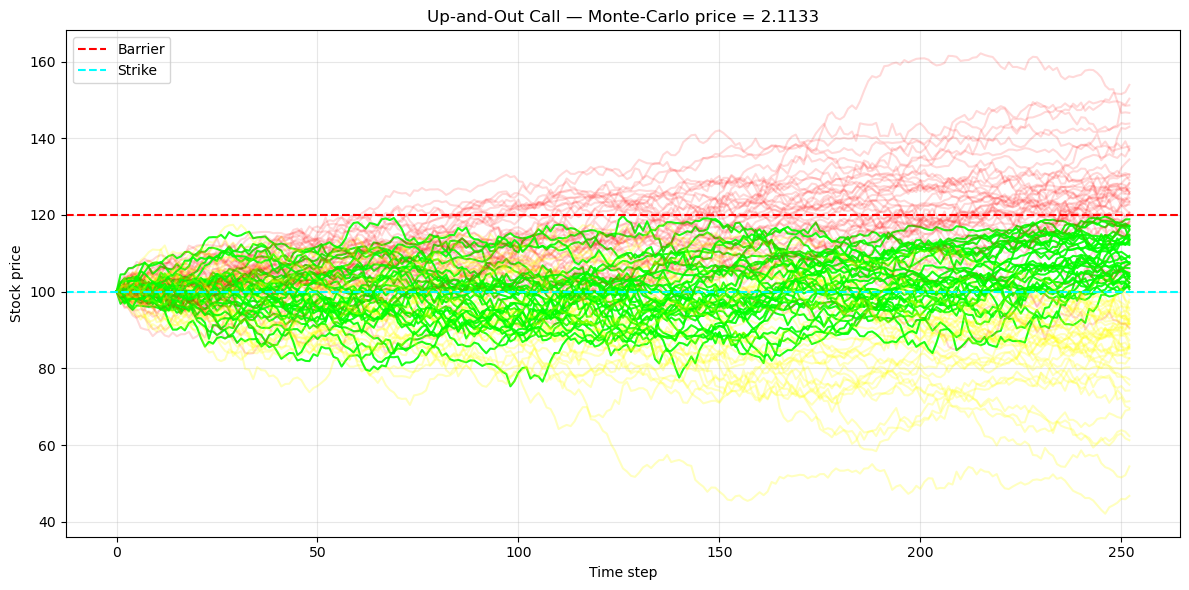

Estimated option price: 2.1133


In [76]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_barrier_option(num_paths=2000, S0=100, K=100, B=120, T=1,
                            r=0.05, v0=0.04, kappa=2, theta=0.04, sigma=0.3, rho=-0.7):
    """
    Up-and-out call under the Heston model (Monte-Carlo).
    Returns (price, simulated_paths).
    """
    dt = 1/252
    N  = int(T/dt)

    S = np.zeros((num_paths, N+1))
    v = np.zeros((num_paths, N+1))
    S[:, 0] = S0
    v[:, 0] = v0

    Z1 = np.random.normal(size=(num_paths, N))
    Z2 = rho*Z1 + np.sqrt(1-rho**2)*np.random.normal(size=(num_paths, N))

    for t in range(N):
        S[:, t+1] = S[:, t] * np.exp((r - 0.5*v[:, t])*dt + np.sqrt(v[:, t]*dt)*Z1[:, t])
        v[:, t+1] = np.maximum(v[:, t] + kappa*(theta - v[:, t])*dt +
                               sigma*np.sqrt(v[:, t]*dt)*Z2[:, t], 0.0)

    max_prices = np.maximum.accumulate(S, axis=1)
    barrier_not_hit = (max_prices[:, -1] < B)

    payoff = np.maximum(S[:, -1] - K, 0.0) * barrier_not_hit
    price  = np.exp(-r*T) * np.mean(payoff)

    return price, S


def plot_barrier_paths(S, B=120, K=100, price=None, num_display=120):
    """
    Plot example stock paths and mark barrier + strike.
    """
    plt.figure(figsize=(12, 6))

    final = S[:, -1]
    maxv  = np.maximum.accumulate(S, axis=1)[:, -1]
    barrier_hit = (maxv >= B)
    itm = (final > K)

    for i in range(min(len(S), num_display)):
        if barrier_hit[i]:
            plt.plot(S[i], color="red", alpha=0.15)
        elif itm[i]:
            plt.plot(S[i], color="lime", alpha=0.9)
        else:
            plt.plot(S[i], color="yellow", alpha=0.25)

    plt.axhline(B, color="red", linestyle="--", label="Barrier")
    plt.axhline(K, color="cyan", linestyle="--", label="Strike")

    if price is not None:
        plt.title(f"Up-and-Out Call — Monte-Carlo price = {price:.4f}")
    else:
        plt.title("Up-and-Out Call — Simulated Paths")

    plt.xlabel("Time step")
    plt.ylabel("Stock price")
    plt.grid(alpha=0.3)
    plt.legend(facecolor='none')
    plt.tight_layout()
    plt.show()


# -------- run once --------
price, S = simulate_barrier_option(num_paths=3000)
plot_barrier_paths(S, B=120, K=100, price=price)


print("Estimated option price:", round(price, 4))


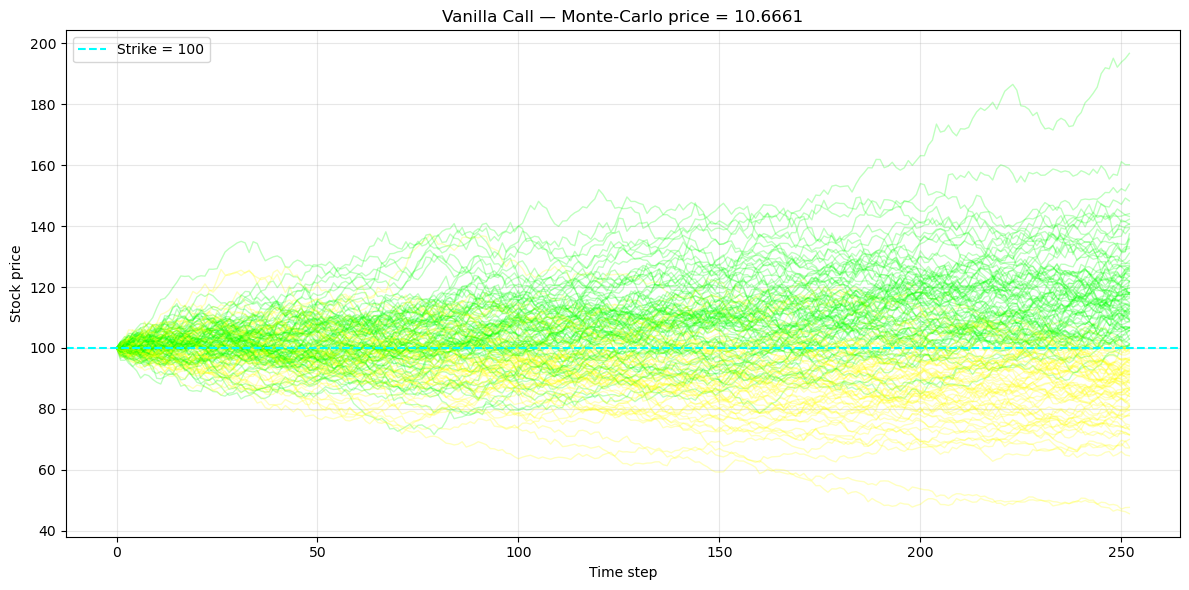

Estimated option price: 10.6661


In [77]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_vanilla_call(S0=100, K=100, r=0.05, sigma=0.2,
                          T=1.0, num_paths=2000, num_steps=252):
    """
    Monte-Carlo price of a European call under Black–Scholes.
    Returns (price, simulated paths).
    """
    dt = T / num_steps
    S = np.zeros((num_paths, num_steps+1))
    S[:, 0] = S0

    for t in range(num_steps):
        Z = np.random.standard_normal(num_paths)
        S[:, t+1] = S[:, t] * np.exp(
            (r - 0.5*sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )

    payoffs = np.maximum(S[:, -1] - K, 0.0)
    price = np.exp(-r*T) * np.mean(payoffs)

    return price, S


def plot_vanilla_paths(S, K=100, price=None, num_display=150):
    """
    Plot sample simulated stock paths and mark the strike.
    """
    plt.figure(figsize=(12, 6))

    for i in range(min(len(S), num_display)):
        color = "lime" if S[i, -1] > K else "yellow"
        plt.plot(S[i], color=color, alpha=0.25, linewidth=1)

    plt.axhline(K, color="cyan", linestyle="--", label=f"Strike = {K}")
    if price is not None:
        plt.title(f"Vanilla Call — Monte-Carlo price = {price:.4f}")
    else:
        plt.title("Vanilla Call — Simulated Paths")

    plt.xlabel("Time step")
    plt.ylabel("Stock price")
    plt.grid(alpha=0.3)
    plt.legend(facecolor="none")
    plt.tight_layout()
    plt.show()


# -------- run once --------
price, S = simulate_vanilla_call(num_paths=3000)
plot_vanilla_paths(S, K=100, price=price)

print("Estimated option price:", round(price, 4))


#### <u>Price Adjustments</u>

After calculating the base exotic option price using our calibrated model, several adjustments are typically made:

 Counterparty Risk Adjustment
- Credit Value Adjustment (CVA) accounts for counterparty default risk
- Debt Value Adjustment (DVA) accounts for own default risk 
- These adjustments reduce the price when default risk is higher

Liquidity Adjustment  
- Exotic options are less liquid than vanilla options
- Wider bid-ask spreads reflect higher hedging costs
- Size of adjustment depends on:
  - Option complexity
  - Market conditions
  - Position size

Profit Margin
- Trading desks add profit margin to cover:
  - Operating costs
  - Capital charges
  - Return on equity requirements
- Typical margins range from 2-10% depending on:
  - Client relationship
  - Competition
  - Market conditions

The final quote sent to clients incorporates all these adjustments on top of the theoretical price.
 Let $Q$ be the final quote sent to clients. Then:

 $Q = P + CVA + DVA + L + M$

 where:
 - $P$ is the theoretical price from the calibrated model
 - $CVA$ is the credit value adjustment
 - $DVA$ is the debt value adjustment  
 - $L$ is the liquidity adjustment
 - $M$ is the profit margin

**You're then ready to fire off that quote on IB**

## Fast Fourier Transform

#### Bivariate Normal Dis. and ITS Characteristics Fn.

In [81]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Generate grid points
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# Calculate bivariate normal PDF
mu = np.array([0, 0])
sigma = np.array([[1, 0.5], [0.5, 1]])
inv_sigma = np.linalg.inv(sigma)
det_sigma = np.linalg.det(sigma)

Z = np.zeros_like(X)
for i in range(len(x)):
    for j in range(len(y)):
        point = np.array([X[i,j], Y[i,j]])
        Z[i,j] = (1/(2*np.pi*np.sqrt(det_sigma))) * np.exp(-0.5 * point.dot(inv_sigma).dot(point))

# Calculate characteristic function
u = np.linspace(-2, 2, 100)
v = np.linspace(-2, 2, 100)
U, V = np.meshgrid(u, v)

# Characteristic function for bivariate normal
CF_real = np.zeros_like(U)
CF_imag = np.zeros_like(U)
for i in range(len(u)):
    for j in range(len(v)):
        t = np.array([U[i,j], V[i,j]])
        CF = np.exp(1j * t.dot(mu) - 0.5 * t.dot(sigma).dot(t))
        CF_real[i,j] = CF.real
        CF_imag[i,j] = CF.imag

# Create figure with subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=('Bivariate Normal PDF', 'Characteristic Function (Real Part)')
)

# Add PDF surface plot
fig.add_trace(
    go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale='Viridis',
        opacity=0.7,
        showscale=True
    ),
    row=1, col=1
)

# Add characteristic function surface plot
fig.add_trace(
    go.Surface(
        x=U,
        y=V,
        z=CF_real,
        colorscale='RdBu',
        opacity=0.7,
        showscale=True
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title='Bivariate Normal Distribution and its Characteristic Function',
    width=1600,
    height=800,
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white'),
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='PDF',
        xaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        yaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        zaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        bgcolor='rgba(0,0,0,0)',
    ),
    scene2=dict(
        xaxis_title='u',
        yaxis_title='v',
        zaxis_title='Re(CF)',
        xaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        yaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        zaxis=dict(gridcolor='darkgray', showgrid=True, color='darkgray', backgroundcolor='rgb(30, 30, 35)'),
        bgcolor='rgba(0,0,0,0)',
    )
)

fig.show()


#### Carr Madan

In [83]:
import numpy as np
from dataclasses import dataclass

# =========================
# Heston + Carr–Madan (FFT)
# =========================

@dataclass
class HestonParams:
    kappa: float
    theta: float
    sigma: float
    rho: float
    v0: float

def heston_cf(u, T, S0, r, q, p: HestonParams):
    """
    Characteristic function φ(u) = E[exp(i u ln S_T)] under Q.
    Uses the Little Heston Trap parametrization.
    u can be scalar or numpy array.
    """
    i = 1j
    x0 = np.log(S0)
    a  = p.kappa * p.theta
    b  = p.kappa - p.rho * p.sigma * i * u
    d  = np.sqrt(b*b + (p.sigma**2) * (i*u + u*u))
    g  = (b - d) / (b + d)

    eDT = np.exp(-d * T)
    one_minus_g_eDT = 1 - g * eDT
    one_minus_g     = 1 - g
    # small guards
    one_minus_g_eDT = np.where(np.abs(one_minus_g_eDT) < 1e-15, 1e-15, one_minus_g_eDT)
    one_minus_g     = np.where(np.abs(one_minus_g)     < 1e-15, 1e-15, one_minus_g)

    C = i*u*(r - q)*T + (a/(p.sigma**2)) * ((b - d)*T - 2.0*np.log(one_minus_g_eDT/one_minus_g))
    D = ((b - d)/(p.sigma**2)) * ((1 - eDT) / one_minus_g_eDT)
    return np.exp(C + D*p.v0 + i*u*x0)

def _simpson_weights(N: int):
    """Simpson weights on an N-point uniform grid (N must be even)."""
    if N % 2 != 0:
        raise ValueError("N must be even for Simpson weights.")
    w = np.ones(N)
    w[1:N-1:2] = 4
    w[2:N-2:2] = 2
    return w

def heston_fft_calls(
    S0: float,
    T: float,
    r: float,
    q: float,
    p: HestonParams,
    N: int = 4096,      # power-of-two recommended; must be even
    eta: float = 0.25,  # frequency step Δv
    alpha: float = 1.5  # damping (>0)
):
    """
    Carr–Madan FFT for call prices across a K-grid.
    IMPORTANT: k = ln K (log-STRIKE), not ln(K/S0).

    Returns
    -------
    K : (N,) ascending strikes
    C : (N,) call prices for these K
    """
    n = np.arange(N)
    v = eta * n  # frequency grid

    i = 1j
    # ψ(v) = e^{-rT} φ(v - i(α+1)) / [(α + iv)(α + iv + 1)]
    phi_shift = heston_cf(v - (alpha + 1)*i, T, S0, r, q, p)
    denom = (alpha**2 + alpha - v**2 + i*(2*alpha + 1)*v)  # (α+iv)(α+iv+1)
    psi = np.exp(-r*T) * phi_shift / denom

    # Simpson weights for the v-integral
    w = _simpson_weights(N) * (eta / 3.0)

    # FFT coupling
    lam = 2.0 * np.pi / (N * eta)   # Δk (log-strike step)
    b   = 0.5 * N * lam             # half-width in k
    x   = psi * np.exp(1j * b * v) * w

    F   = np.fft.fft(x)
    F   = np.real(F)

    j = np.arange(N)
    k = -b + j * lam                 # k = ln K
    K = np.exp(k)

    calls = np.exp(-alpha * k) / np.pi * F
    order = np.argsort(K)
    return K[order], np.maximum(calls[order], 0.0)

def heston_fft_call_price(
    S0: float, K: float, T: float, r: float, q: float, p: HestonParams,
    N: int = 4096, eta: float = 0.25, alpha: float = 1.5
):
    """Price a single call via FFT + linear interpolation on the K-grid."""
    K_grid, C_grid = heston_fft_calls(S0, T, r, q, p, N=N, eta=eta, alpha=alpha)
    if K <= K_grid[0]:
        return C_grid[0]
    if K >= K_grid[-1]:
        return C_grid[-1]
    idx = np.searchsorted(K_grid, K)
    x0, x1 = K_grid[idx-1], K_grid[idx]
    y0, y1 = C_grid[idx-1], C_grid[idx]
    return y0 + (y1 - y0) * (K - x0) / (x1 - x0)

def heston_fft_put_price(
    S0: float, K: float, T: float, r: float, q: float, p: HestonParams,
    N: int = 4096, eta: float = 0.25, alpha: float = 1.5
):
    """Put via put–call parity."""
    C = heston_fft_call_price(S0, K, T, r, q, p, N=N, eta=eta, alpha=alpha)
    return C - S0*np.exp(-q*T) + K*np.exp(-r*T)

In [84]:
# parameters
S0, r, q, T = 100.0, 0.01, 0.00, 1.0
hp = HestonParams(kappa=1.5, theta=0.04, sigma=0.3, rho=-0.7, v0=0.04)

# full grid of calls
K, C = heston_fft_calls(S0, T, r, q, hp, N=4096, eta=0.25, alpha=1.5)

# single strikes
call_100 = heston_fft_call_price(S0, 100, T, r, q, hp)

call_100

8.07774347291964

In [85]:
# Simulate Heston price with given parameters
S0 = 100          # Initial stock price
K = 100           # Strike price  
T = 1             # Time to maturity
r = 0.01          # Risk-free rate
v0 = 0.04         # Initial variance
kappa = 2         # Mean reversion speed
theta = 0.04      # Long-run variance
sigma = 0.3       # Volatility of variance
rho = -0.7        # Correlation
N = 16384         # Number of grid points
alpha = 1.5       # Damping factor

# Simulation parameters
n_paths = 10000   # Number of paths
n_steps = 252     # Number of time steps (daily)
dt = T/n_steps    # Time step size

# Initialize arrays for paths
S = np.zeros((n_paths, n_steps + 1))
v = np.zeros((n_paths, n_steps + 1))

# Set initial values
S[:, 0] = S0
v[:, 0] = v0

# Generate correlated random numbers
rng = np.random.default_rng()
dW1 = rng.normal(0, np.sqrt(dt), (n_paths, n_steps))
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * rng.normal(0, np.sqrt(dt), (n_paths, n_steps))

# Euler-Maruyama simulation
for t in range(n_steps):
    # Ensure variance stays positive
    v[:, t] = np.maximum(v[:, t], 0)
    
    # Update stock price
    S[:, t+1] = S[:, t] * np.exp((r - 0.5*v[:, t])*dt + np.sqrt(v[:, t])*dW1[:, t])
    
    # Update variance
    v[:, t+1] = v[:, t] + kappa*(theta - v[:, t])*dt + sigma*np.sqrt(v[:, t])*dW2[:, t]

# Calculate call option prices
payoffs = np.maximum(S[:, -1] - K, 0)
discounted_payoffs = np.exp(-r*T) * payoffs
price = np.mean(discounted_payoffs)

# Calculate 95% confidence interval
std_error = np.std(discounted_payoffs) / np.sqrt(n_paths)
ci_lower = price - 1.96 * std_error
ci_upper = price + 1.96 * std_error

print(f"Heston call option price: {price:.8f}")
print(f"95% Confidence Interval: [{ci_lower:.8f}, {ci_upper:.8f}]")

Heston call option price: 8.19990055
95% Confidence Interval: [7.98598487, 8.41381623]


In [86]:
# Generate strike grid centered around S0
strikes = np.arange(S0-20, S0+25, 5)

# Get FFT prices for all strikes
K_fft, C_fft = heston_fft_calls(S0, T, r, q, hp, N=4096, eta=0.25, alpha=1.5)

# Interpolate FFT prices to our strike grid
fft_prices = np.interp(strikes, K_fft, C_fft)

# Calculate MC prices for all strikes
mc_prices = []
mc_ci_lower = []
mc_ci_upper = []

for K in strikes:
    payoffs = np.maximum(S[:, -1] - K, 0)
    discounted_payoffs = np.exp(-r*T) * payoffs
    price = np.mean(discounted_payoffs)
    
    # Calculate 95% confidence interval
    std_error = np.std(discounted_payoffs) / np.sqrt(n_paths)
    mc_prices.append(price)
    mc_ci_lower.append(price - 1.96 * std_error)
    mc_ci_upper.append(price + 1.96 * std_error)

# Print comparison table
print("\nPrice Comparison:")
print("Strike   FFT Price   MC Price   MC 95% CI")
print("-" * 45)
for i in range(len(strikes)):
    print(f"{strikes[i]:6.1f}   {fft_prices[i]:9.4f}   {mc_prices[i]:8.4f}   [{mc_ci_lower[i]:8.4f}, {mc_ci_upper[i]:8.4f}]")



Price Comparison:
Strike   FFT Price   MC Price   MC 95% CI
---------------------------------------------
  80.0     22.3804    22.4247   [ 22.1033,  22.7462]
  85.0     18.2617    18.3079   [ 18.0072,  18.6085]
  90.0     14.4595    14.5204   [ 14.2450,  14.7957]
  95.0     11.0425    11.1272   [ 10.8810,  11.3734]
 100.0      8.0777     8.1999   [  7.9860,   8.4138]
 105.0      5.6161     5.7691   [  5.5891,   5.9491]
 110.0      3.6817     3.8336   [  3.6871,   3.9800]
 115.0      2.2629     2.3988   [  2.2841,   2.5136]
 120.0      1.2993     1.4025   [  1.3158,   1.4893]
